# Mid Semester Project - DEEP Reinforcements Learning
# ENV1 - EMPTY GRID ENVIRONMENT
Dear students,<br> this is the template notebook. Please copy it by clicking on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1:
<br>
Student 2:
<br>

<br>

<img src="https://raw.githubusercontent.com/Farama-Foundation/Minigrid/master/minigrid-text.png">

### https://minigrid.farama.org/

# Pre-Requisit

## Installs

In [ ]:
# Uncomment the following lines if you are running this notebook in Google Colab to install required dependencies

'''
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install gym-minigrid
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install -U --no-cache-dir gdown --pre
'''

## Imports

In [13]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
import seaborn as sns
import gym_minigrid
from gym_minigrid.wrappers import *
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from numpy import load
from numpy import save
import numpy as np
import pandas as pd
import cv2
from base64 import b64encode
import os
import torch
import torch.nn as nn
from torch.optim import SGD
from collections import namedtuple, deque
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Display utils
Note: this cell was changed in order to support also working on windows os, as PyVirtualDisplay doesn't work on windows. link for reference: https://stackoverflow.com/questions/43270513/is-there-a-windows-equivalent-to-pyvirtualdisplay

In [14]:
if os.name == 'nt': # this means we run locally on windows
  video_count = 0
  def create_video(images):
    global video_count
    video_count += 1
    video_name = f'video_{video_count}.mp4'
    frame = images[0]
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 3, (width,height))

    for image in images:
      video.write(image)

    cv2.destroyAllWindows()
    video.release()
  
    mp4 = open(video_name,'rb').read()   
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(
      HTML(
            """
                <video width=400 controls>
                        <source src="%s" type="video/mp4">
                </video>
            """ % data_url
          )   
    )
    print(f'video file name: {video_name}')
      
else: # this is posix, as it runs online. use assigment video solution
  def create_video(images):
    video_filename = 'imageio.mp4'
    with imageio.get_writer(video_filename, fps=10) as video:
        for image in images: video.append_data(image)

    video = open(video_filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
      <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)
  display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start() 

# Env

In [40]:
from __future__ import annotations
from gym_minigrid.minigrid import COLOR_NAMES
from gym_minigrid.minigrid import Grid
from gym_minigrid.minigrid import MissionSpace
from gym_minigrid.minigrid import Door, Goal, Key, Wall, Lava, Floor
from minigrid_x import MiniGridEnv
from gym import spaces
import random

class RandomEmptyEnv_10(MiniGridEnv):
    def __init__(
        self,
        size=10, # DEFINE THE WIDTH AND HEIGHT
        agent_start_pos=(1, 1),
        agent_start_dir = 0,
        max_steps: int | None = None,
        **kwargs,
    ):

        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        agent_start_x_loc =random.randint(1, 6)
        agent_start_y_loc =random.randint(1, 6)

        self.agent_start_pos = (agent_start_x_loc,agent_start_y_loc)

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )
        self.action_space = spaces.Discrete(3)
        self.walls_init = []

        # change 21-09 for random env
        self.not_goal_loc = [(col,row) for col in range(self.unwrapped.width) for row in range(self.unwrapped.height) if row == 0 or row == (self.unwrapped.width-1) or col == 0 or col == (self.unwrapped.height-1)]
        self.not_goal_loc.append(self.agent_start_pos)
        self.goal_pos = (self.grid.width - 2, self.grid.height - 2)

    def reset(self, **kwargs):
        # Randomize start position each time environment is reset
        agent_start_x_loc = random.randint(1, 6)
        agent_start_y_loc = random.randint(1, 6)
        self.agent_start_pos = (agent_start_x_loc, agent_start_y_loc)

        self.values = [0, 1, 2, 3]
        self.agent_start_dir = random.choice(self.values)

        # Recalculate not_goal_loc as it depends on the agent's start position
        self.not_goal_loc = [(col, row) for col in range(self.unwrapped.width) for row in range(self.unwrapped.height)
                             if row == 0 or row == (self.unwrapped.width - 1) or col == 0 or col == (self.unwrapped.height - 1)]
        self.not_goal_loc.append(self.agent_start_pos)

        # Call the reset method of the parent class
        return super().reset(**kwargs)
    
    # Necessary functions for environment customization:
    # - get_position and get_goal_pos: These functions help us determine whether the environment has been solved
    #   Additionally, get_goal_pos aids in gathering metrics related to the agent's performance throughout the training process
    # - is_wall_front_pos: This function assesses whether forward movement is feasible for the agent at the specific state
    
    def get_position(self):
        return self.unwrapped.agent_pos
    
    def get_goal_pos(self):
        return self.unwrapped.goal_pos
    
    def is_wall_front_pos(self):
        if 0 in self.unwrapped.front_pos or (self.unwrapped.height-1) in self.unwrapped.front_pos:
            return True
        return (tuple(self.unwrapped.front_pos) in self.unwrapped.walls_init)

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate verical separation wall
        # for i in range(0, height):
        #     self.grid.set(5, i, Wall())


        for column, row in self.walls_init:
          self.grid.set(column, row, Wall())

        self.key_pos = (6, 5)
        self.door_pos = (6, 7)

        self.goal_pos = random.choice([(8,1), (8,8), (1,8)])

        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"


## WRAPPER

In [39]:
class EMPTYRGBImgObsWrapper(gym.core.ObservationWrapper):
    """
    Wrapper to use fully observable RGB image as the only observation output,
    no language/mission. This can be used to have the agent to solve the
    gridworld in pixel space.
    """

    def __init__(self, env, tile_size=32, plot=False, preprocess= lambda x: x):
        super().__init__(env)
        self.tile_size = tile_size
        self.plot = plot
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            # #the default is (320,320,3). Tile size  = 32 X 10 (grid size)
            # TODO: BE CAREFULL TO CHANGE the shape size to be according your preprocess size/channels
            # The env information i staken from here
            shape=(320, 320, 3),
            dtype='uint8'
        )
        self.prev_door = False
        self.prev_key = False
        self.action_space = spaces.Discrete(self.action_space.n)

        #TODO: THINK AND TEST DIFFERENT PREPROCESS
        self._preprocess = lambda x: x


    def observation(self, obs):
      env = self.unwrapped

      # Call render without any unsupported keyword arguments
      rgb_img = env.render()  # Use the default rendering behavior
      return rgb_img

    def reset(self, seed = 0, options = None):
        self.prev_door = False
        self.prev_key = False
        obs, info = super().reset()
        if self.plot:
            plt.show()
        return self._preprocess(obs), info

    def step(self, action):
        #action = ACTION_MAP[action]
        obs, r, d, info, x = super().step(action)
        obs = self._preprocess(obs)

        # TODO: REWARD SHAPING
        #we encourage you to come up with a better reward function using  self.is_door_open() and self.is_carrying_key()

        return obs, r, d, info, x

Environment Customization:

In [17]:
from enum import Enum
from abc import ABC, abstractmethod

agent_directions_space = 4
key_state_space = 2
door_state_space = 2

key_picked_up_reward = 1 # these are constant rewards
door_unlocked_reward = 1

class Direction(Enum):
    RIGHT = 0
    DOWN = 1
    LEFT = 2
    UP = 3

class StateRepresentation(Enum):
    IMAGE = 'image'
    ENCODED = 'encoded'

class EnvWrapper(gym.Env, ABC):
    '''
    This wrapper enables environment customization
    '''
    def __init__(self, env, step_reward=-0.01, goal_reward=10, state_representation=StateRepresentation.ENCODED):
        '''
        Initializes the EnvWrapper.

        Args:
            env (gym.Env): The Gym environment to be wrapped. Important: this env must be initialized before wrapping (use env.reset())
            step_reward (float, optional): The per-step reward or penalty. Default is -0.01.
            goal_reward (float, optional): The reward for reaching the goal. Default is 10.
            state_representation (StateRepr, optional): The state representation mode.
                                                        Use StateRepr.IMAGE for a full image representation, or StateRepr.ENCODED for an encoded version
                                                        Default is StateRepr.ENCODED
        '''
        self.state_representation = state_representation

        self.source_env = env
        self.set_params(step_reward, goal_reward)
        self.reset()

    def reset(self): # open gym default implementation changes the board. override, as we do not want to change the board upon reset every time
        self.env = copy.deepcopy(self.source_env)
        return self.get_current_state()

    def set_params(self, step_reward, goal_reward):
        self.step_reward = step_reward
        self.goal_reward = goal_reward

    def get_current_state(self):
        if StateRepresentation.IMAGE == self.state_representation:
            current_state = self.env.render()
        else:
            current_state = self.get_encoded_current_state()
        return current_state

    def render(self):
        return self.env.render()

    def get_state_dim(self):
        if StateRepresentation.IMAGE == self.state_representation:
            state_dim = self.env.render().shape
        else: # this is encoded mode
            state_dim = self.get_encoded_state_dim()
        return state_dim

    def get_board_dims(self):
        cols = self.env.width - 2
        rows = self.env.height - 2
        return cols, rows

    def get_action_dim(self):
        return self.env.action_space.n

    def sample_action(self):
        available_actions = self.get_available_actions()
        sampled_action = random.choice(available_actions)
        return sampled_action

    def get_agent_position(self):
        col, row = self.env.get_position()
        return col - 1, row - 1

    @abstractmethod
    def get_available_actions(self):
        pass

    @abstractmethod
    def get_encoded_state_dim(self):
        pass

    @abstractmethod
    def get_encoded_current_state(self):
        pass

    @abstractmethod
    def step(self, action):
        pass

class EmptyEnvWrapper(EnvWrapper):
    def get_available_actions(self):
        available_actions = [0, 1]
        if not self.env.is_wall_front_pos(): # the agent is not standing in front of a wall - if so, we can proceed forward (2)
            available_actions.append(2)
        return available_actions

    def get_encoded_state_dim(self):
        cols, rows = self.get_board_dims()
        return cols, rows, agent_directions_space

    def get_encoded_current_state(self):
        agent_col, agent_row = self.get_agent_position()
        agent_direction = self.env.get_direction()
        state = (agent_col, agent_row, agent_direction)  # remove extra row \ col in the board perimeter
        return state

    def step(self, action):
        _ = self.env.step(action)
        s_tag = self.get_current_state()
        done = self.env.get_goal_pos() == self.env.get_position() # compare agent location to target location
        r = self.goal_reward if done else self.step_reward
        return s_tag, r, done

# DQN Algorithm

The DQN algorithm:

In [43]:
Transition = namedtuple('transition', ('state', 'action', 'reward', 'next_state'))

class QNN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNN, self).__init__()
        # Simplify the convolution layers to reduce parameters and focus on essential feature extraction
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=8, stride=4),  # Reduced number of filters
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),  # Reduced number of filters
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1),  # Maintain this layer for spatial feature extraction
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        # Assuming an adjustment based on the output size from the conv layers
        self.fc = nn.Linear(41472, state_dim)  # Adjusted based on assumed conv output, leading to a single dense layer
        self.relu = nn.ReLU()  # ReLU activation function between the linear layers
        self.output_layer = nn.Linear(state_dim, action_dim)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.relu(x)  # Applying ReLU activation here
        x = self.output_layer(x)
        return x

class ExperienceReplayBuffer:
    def __init__(self, memory_buffer_size):
        self.buffer = deque([], maxlen=memory_buffer_size)
    def push(self, state, action, reward, next_state):
        t = (state, action, reward, next_state)
        self.buffer.append(t)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.buffer)

def state_to_tensor(state, done=False):
    if done:
        return None
    else:
        return torch.tensor(state, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

def create_policy(policy_net):
    policy_net_snapshot = copy.deepcopy(policy_net)
    def policy(s):
        '''
        This function gets a state and returns the preferable action.
        It does it by providing the state to the network and returning the action with maximal q-value
        (i.e. this is a greedy policy_net)
        '''
        state_tensor = state_to_tensor(s)
        with torch.no_grad():
            q_values = policy_net_snapshot(state_tensor)
        a = q_values.max(1)[1].view(1, 1)
        return a.item()
    return policy

def pick_action(epsilon, state, env, policy_net):
    '''
    Selects an action based on the epsilon-greedy strategy, which balances exploration and exploitation.
    '''
    if random.random() >= epsilon: # exploitation
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else: # exploration
        return torch.tensor([[env.sample_action()]], dtype=torch.long)

def update_target_net(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())

def update_epsilon(epsilon, ep_decay):
    ep = max(epsilon * ep_decay, 0.05)
    return ep

def train_policy_network(buffer, policy_net, target_net, batch_size, gamma, optimizer, criterion):
    # Step 1: sample from data and create the required tensors
    batch = buffer.sample(batch_size)
    state_tensor = torch.cat(batch.state)
    action_tensor = torch.cat(batch.action)
    reward_tensor = torch.cat(batch.reward)
    next_state_tensor = torch.cat([next_state for next_state in batch.next_state if next_state is not None])
    non_final_state_mask_tensor = torch.tensor(tuple(map(lambda next_state: next_state is not None, batch.next_state)), dtype=torch.bool)

    # Step 2: Calculate Q-values for current states and selected actions
    q_values_tensor = policy_net(state_tensor).gather(1, action_tensor)

    # Step 3: Calculate the maximum Q-values for the next states using the target network
    next_q_values_tensor = torch.zeros(batch_size)
    with torch.no_grad():
        next_q_values_tensor[non_final_state_mask_tensor] = target_net(next_state_tensor).max(1)[0]  # Note: final states remains with reward of 0
    target_q_values = (next_q_values_tensor * gamma) + reward_tensor

    # Step 4: Calculate the loss and update the model accordingly
    loss = criterion(q_values_tensor, target_q_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def dqn(env, num_episodes, batch_size, gamma, ep_decay, epsilon,
        target_freq_update, memory_buffer_size, learning_rate, steps_cutoff, train_action_value_freq_update):
    action_dim = env.get_action_dim()
    state_dim = math.prod(env.get_encoded_state_dim())
    policy_net = QNN(state_dim, action_dim)
    target_net = QNN(state_dim, action_dim)
    update_target_net(policy_net, target_net)
    criterion = torch.nn.MSELoss()

    buffer = ExperienceReplayBuffer(memory_buffer_size)
    optimizer = SGD(policy_net.parameters(), lr=learning_rate)

    cols, rows = env.get_board_dims()
    states_visits_count = np.zeros([cols, rows], dtype=float) # Initialize stats' data structures

    done_count = 0
    episodes_loss, episodes_rewards, episodes_steps = [], [], []

    for i in range(1, num_episodes+1):
        print(f'\nRunning episode {i}\\{num_episodes}\nPrinting steps progress (up to {steps_cutoff} steps): ')

        done = False
        episode_reward = 0
        episode_loss = 0
        num_steps = 1

        state = state_to_tensor(env.reset())
        agent_position = env.get_agent_position()
        states_visits_count[agent_position] += 1

        while not done and num_steps <= steps_cutoff:
            print(num_steps, end = " ")
            action = pick_action(epsilon, state, env, policy_net)
            next_state, reward, done = env.step(action.item())
            episode_reward += reward

            next_state = state_to_tensor(next_state, done)
            reward = torch.tensor([reward])
            buffer.push(state, action, reward, next_state)

            if len(buffer) >= batch_size and num_steps % train_action_value_freq_update == 0:
                loss = train_policy_network(buffer, policy_net, target_net, batch_size, gamma, optimizer, criterion)
                episode_loss += loss

            num_steps += 1
            epsilon = update_epsilon(epsilon, ep_decay)

            next_agent_position = env.get_agent_position()

            if agent_position != next_agent_position: # if the agent moved to a new location on the board
                states_visits_count[next_agent_position] += 1

            state = next_state
            agent_position = next_agent_position

        num_steps = steps_cutoff if not done else num_steps

        episodes_rewards.append(episode_reward)
        episodes_loss.append(episode_loss / num_steps)
        episodes_steps.append(num_steps)

        if i % target_freq_update == 0:
            update_target_net(policy_net, target_net)

        if done:
            done_count += 1

        if num_episodes // 2 == i:
            mid_train_policy = create_policy(policy_net)

    policy = create_policy(policy_net)

    return mid_train_policy, policy, states_visits_count / num_episodes, done_count, episodes_steps, episodes_rewards, episodes_loss

Policy video streaming:

In [33]:
def stream_policy(env, policy, iter_tresshold=None):
  # Step 1: collect images
  state = env.reset()
  start_time = time.time()
  done = False
  iter = 0
  images = []
  images.append(cv2.cvtColor(env.render(), cv2.COLOR_RGB2BGR)) 

  while not(iter_tresshold is not None and iter >= iter_tresshold) and not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = policy(state)
    state, reward, done = env.step(action)
    images.append(cv2.cvtColor(env.render(), cv2.COLOR_RGB2BGR)) 
  # Than - create video
  return create_video(images)

algorithm parameters:

In [20]:
ENV_PARAMS = 'Env_params'
ALGO_PARAMS = 'Algo_params'

#############################
# Experiments configuration #
#############################
'''
Training-phase parameters:
train_num_episodes - the number of episodes for the training
train_steps_cutoff - maximal steps allowed per episode
'''
train_num_episodes = 500
train_steps_cutoff = 100

'''
Evaluation-phase parameters
test_num_episodes - the number of episodes for the evaluation
test_steps_cutoff - maximal steps allowed per episode
'''
test_steps_cutoff = 100

'''
Default hyper-parameters values for the algorithms
'''
algorithm_params = {
    'learning_rate': 0.0001,
    'gamma': 0.9,
    'epsilon': 1,
    'ep_decay': 0.999,
    'num_episodes': train_num_episodes,
    'steps_cutoff': train_steps_cutoff,
    'batch_size': 32,
    'target_freq_update': 10,
    'memory_buffer_size': 10000,
    'train_action_value_freq_update': 1
}

'''
Default hyper-parameters values for env
'''
env_params = {'goal_reward': 10, 'step_reward': -0.01}

# Env Solution

This notebook concentrates on the environmental solution. For an analysis of how various hyperparameter adjustments impact the environment, please refer to the corresponding notebook.

Let's explore the environmental solution in detail:

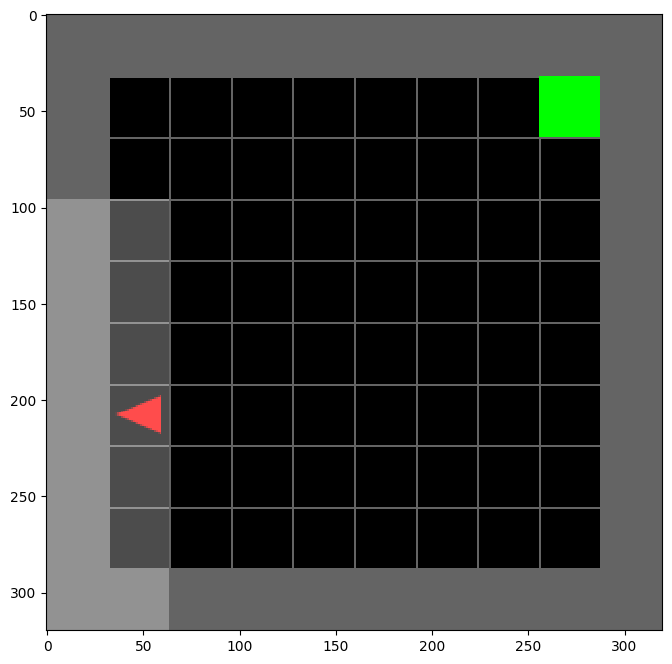

In [41]:
# create and render the env
random.seed(42)
source_env = EMPTYRGBImgObsWrapper(RandomEmptyEnv_10(render_mode='rgb_array'))
source_env.reset()
env = EmptyEnvWrapper(source_env, state_representation=StateRepresentation.IMAGE)
plt.imshow(env.render());

In [45]:
# run the algorithm 
algorithm_params_cpy = algorithm_params.copy()
algorithm_params_cpy['env'] = env

mid_train_policy, policy, states_visits_mean, done_count, episodes_steps, episodes_rewards, episodes_loss = dqn(**algorithm_params_cpy)


Running episode 1\500
Printing steps progress (up to 100 steps): 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
Running episode 2\500
Printing steps progress (up to 100 steps): 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
Running episode 3\500
Printing steps progress (up to 100 steps): 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75

stream mid-training policy:

In [46]:
stream_policy(env, mid_train_policy)

video file name: video_1.mp4


stream final policy:

In [47]:
stream_policy(env, policy)

video file name: video_2.mp4


From the videos, it's evident that the agent quickly discovers the necessary policy, even before reaching the midpoint of training.

To gain a clearer understanding, let's now examine the training policy in more detail.

Monitoring where the agent visited during training:

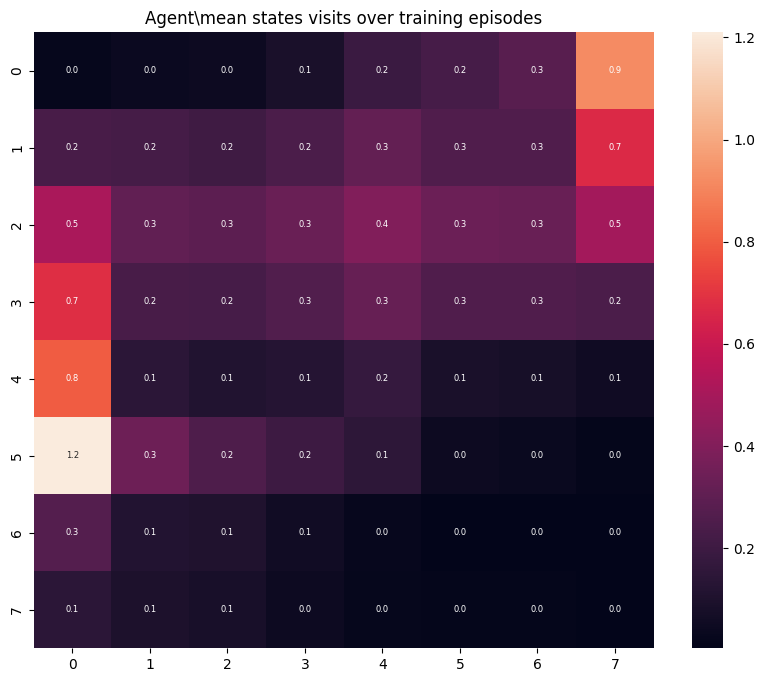

In [48]:
sns.heatmap(states_visits_mean.T, annot=True, fmt='.1f', annot_kws={"size": 6})
plt.title('Agent\\mean states visits over training episodes');

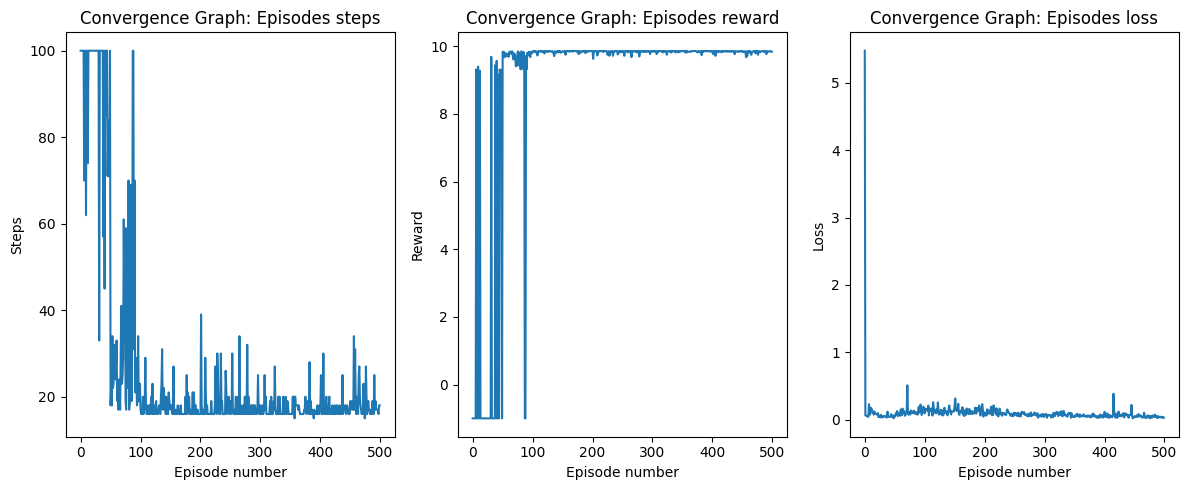

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5)) # Creates 1 row, 2 columns of plots, adjust figsize as needed

# Plot Episodes steps on the first subplot
axs[0].plot(episodes_steps)
axs[0].set_title('Convergence Graph: Episodes steps')
axs[0].set_xlabel('Episode number')
axs[0].set_ylabel('Steps')

# Plot Episodes reward on the second subplot
axs[1].plot(episodes_rewards)
axs[1].set_title('Convergence Graph: Episodes reward')
axs[1].set_xlabel('Episode number')
axs[1].set_ylabel('Reward')

# Plot Episodes loss on the thirs subplot
axs[2].plot(episodes_loss)
axs[2].set_title('Convergence Graph: Episodes loss')
axs[2].set_xlabel('Episode number')
axs[2].set_ylabel('Loss')

plt.tight_layout() # Adjusts subplots to fit into the figure area.